<a href="https://colab.research.google.com/github/pedrov718/chatbot_for_mental_health/blob/main/generative_chatbot_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading data and preliminary analysis

In [1]:
import re
import random
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment', None)

In [2]:
data=pd.read_csv("mentalhealth.csv",nrows=20)

In [3]:
data.head()

,Question_ID,Questions,Answers
0,1590140,What does it mean to have a mental illness?,Mental illnesses are health conditions that di...
1,2110618,Who does mental illness affect?,"Mental illness does can affect anyone, regardl..."
2,9434130,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...
3,7657263,Can people with mental illness recover?,"When healing from mental illness, early identi..."
4,1619387,What should I do if I know someone who appears...,We encourage those with symptoms to talk to th...


In [4]:
df = pd.read_excel("/content/topical_chat.xlsx")

In [5]:
df.head()

,Question
0,Are you a fan of Google or Microsoft?
1,Both are excellent technology they are helpful...
2,"I'm not a huge fan of Google, but I use it a..."
3,Google provides online related services and p...
4,"Yeah, their services are good. I'm just not a..."


In [6]:
df.reset_index(inplace = True)

In [7]:
questions = df[df['index'] % 2 == 0]

answers = df[df['index'] % 2 == 1]

In [8]:
questions.reset_index(inplace = True)

In [9]:
questions.drop(columns = 'index', inplace = True)

In [10]:
questions.rename(columns = {"Question":"Questions"}, inplace = True)

In [11]:
answers.drop(columns = ['index'], inplace = True)

In [12]:
answers.rename(columns = {"Question":"Answers"}, inplace = True)

In [13]:
answers.reset_index(inplace =True)

In [14]:
answers.drop(columns = ['index'], inplace = True)

In [15]:
convo = questions.join(answers)

In [16]:
dialouge = pd.concat([convo, data], ignore_index= True)

In [17]:
dialouge.drop(columns = ['level_0'], inplace = True)

In [18]:
dialouge["Questions"] = dialouge["Questions"].astype(str)

In [19]:
dialouge["Answers"] = dialouge["Answers"].astype(str)

In [20]:
# data preprocessing 

# for i in range(dialouge.shape[0]):
#   dialouge['Answers'][i]=re.sub(r'\n', ' ',dialouge['Answers'][i])
#   dialouge['Answers'][i]=re.sub('\(', '',dialouge['Answers'][i]) 
#   dialouge['Answers'][i]=re.sub(r'\)', '',dialouge['Answers'][i]) 
#   dialouge['Answers'][i]=re.sub(r',', '',dialouge['Answers'][i]) 
#   dialouge['Answers'][i]=re.sub(r'-', '',dialouge['Answers'][i])
#   dialouge['Answers'][i]=re.sub(r'/', '',dialouge['Answers'][i])  
#   dialouge['Answers'][i]=re.sub(r'/', '',dialouge['Answers'][i])

In [21]:
dialouge['Questions']

0                    Are you a fan of Google or Microsoft?
1         I'm not  a huge fan of Google, but I use it a...
2         Yeah, their services are good. I'm just not a...
3        Did you know Google had hundreds of live goats...
4        I like Google Chrome. Do you use it as well fo...
                               ...                        
94204                       Where can I go to find therapy
94205    Where can I learn about types of mental health...
94206    What are the different types of mental health ...
94207              Where can I go to find a support group?
94208               Where can I go to find inpatient care?
Name: Questions, Length: 94209, dtype: object

In [22]:
dialouge['Answers']

0        Both are excellent technology they are helpful...
1         Google provides online related services and p...
2        Google is leading the alphabet subsidiary and ...
3         It is very interesting. Google provide "Chrom...
4         Yes.Google is the biggest search engine and G...
                               ...                        
94204    Several different types of treatment and thera...
94205    Mental health conditions are often treated wit...
94206    There are many types of mental health professi...
94207    Many people find peer support a helpful tool t...
94208    Inpatient care can help people stabilize on ne...
Name: Answers, Length: 94209, dtype: object

In [23]:
pairs=[]

for i in range(dialouge.shape[0]):
  pairs.append(((dialouge['Questions'][i]),dialouge['Answers'][i]))

In [24]:
import random

random.shuffle(pairs)

In [25]:
pairs = pairs[:1000]

## Data preprocessing 

In [26]:
input_docs = []
target_docs = []
input_tokens = set()
target_tokens = set()

for line in pairs:

  input_doc, target_doc = line[0], line[1]

  # Appending each input sentence to input_docs
  input_docs.append(input_doc)

  # Splitting words from punctuation  
  target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))

  # Redefine target_doc below and append it to target_docs
  target_doc = '<START> ' + target_doc + ' <END>'

  target_docs.append(target_doc)

  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)
  for token in target_doc.split():
    if token not in target_tokens:
      target_tokens.add(token)

input_tokens = sorted(list(input_tokens))  # contains all words of input_docs
target_tokens = sorted(list(target_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

In [27]:
input_docs[:20]

['Did you know Jon Hamm taught drama at his high school?  Thats awesome!',
 'i woudl probably have made the same mistake. who knew what facebook would become.',
 'I read that! I know that certain buildings in NY have their own area codes too!',
 'Same here!  Have a great night!',
 " Did he really? That's kind of funny! I also think it's funny that the US president's guest house is actually bigger than the white house itself. It's like, I didn't even know the president had a guest house!",
 " That's true. We're not as good as hungry was back in the 50s, they had a 6-year. Where they only had one defeat. That's insane!",
 'I bet their desire for a look changed - he looked a bit younger!',
 'Yes and they lay on the bottom of the ocean floor',
 " At least he's honest.  Speaking of honesty, I think my wife only like these shows because of the actors.  Mad Men and Jon Hamm,  House and Hugh Laurie, Walking Dead because of Andrew somebody, I forget.",
 "Google paid 1.65 billion for youtube in 

In [28]:
target_docs[:20]

['<START> No , not really could you tell more about it ? <END>',
 '<START> It has definitely become a big deal . Some countries laws even include facebook . In Germany the " like " button is illegal . <END>',
 '<START> I guess people go overboard on phones because Unicef will donate a day of clean water to a child in need for every minute we are not on our phones . <END>',
 '<START> Hey do use Amazon ? I have Amazon Prime personally . <END>',
 "<START> Yeah , I'm not sure if that is true . I've been on a tour of the white house . <END>",
 "<START> At lease we haven't placed below 3rd since 1991 <END>",
 "<START> True . And then Bill Nye won a Steve Martin lookalike contest which gave him a break in the entertainment industry . Honestly , I don't think they look alike ! Ha ! <END>",
 '<START> Yeah . It was nice chatting with you <END>',
 '<START> Hilarious ! Well , did you know all of the roads in Japan are tolls ? <END>',
 '<START> It certainly is . Add to that fact , most of the conte

In [29]:
input_features_dict = dict([(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict([(token, i) for i, token in enumerate(target_tokens)])

reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict((i, token) for token, i in target_features_dict.items())

In [30]:
input_features_dict

{'!': 0,
 '"': 1,
 '$': 2,
 '%': 3,
 '&': 4,
 "'20s": 5,
 "'87": 6,
 "'91": 7,
 '(': 8,
 ')': 9,
 '+': 10,
 ',': 11,
 '-': 12,
 '.': 13,
 '/': 14,
 '0': 15,
 '000': 16,
 '04': 17,
 '1': 18,
 '10': 19,
 '100': 20,
 '1000': 21,
 '12': 22,
 '12AM': 23,
 '12am': 24,
 '13': 25,
 '137': 26,
 '15': 27,
 '16': 28,
 '160': 29,
 '160mph': 30,
 '17': 31,
 '175': 32,
 '18': 33,
 "1800's": 34,
 '1805': 35,
 '1853': 36,
 '1869': 37,
 '1886': 38,
 "1900's": 39,
 '1900s': 40,
 '1916': 41,
 '1926': 42,
 '1930': 43,
 '1934': 44,
 '1940s': 45,
 '1947': 46,
 '1949': 47,
 '1957': 48,
 '1958': 49,
 '1960s': 50,
 '1969': 51,
 '1972': 52,
 '1973': 53,
 '1985': 54,
 '1986': 55,
 '1989': 56,
 '1993': 57,
 '1994': 58,
 '1995': 59,
 '1997': 60,
 '1998': 61,
 '1billion': 62,
 '1g': 63,
 '2': 64,
 '20': 65,
 '200': 66,
 '2000': 67,
 '2002': 68,
 '2003': 69,
 '2005': 70,
 '2006': 71,
 '2007': 72,
 '2011': 73,
 '2013': 74,
 '2016': 75,
 '2018': 76,
 '2022': 77,
 '20c': 78,
 '212': 79,
 '21st': 80,
 '220': 81,
 '222':

## Encoder - Decoder model

In [31]:
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
#max_encoder_seq_length = 100
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])
#max_decoder_seq_length = 100

encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        #Assign 1. for the current line, timestep, & word in encoder_input_data
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.
    
    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.

In [32]:
encoder_input_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [33]:
decoder_target_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

## Training

In [34]:
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model  
dimensionality = 256 # Dimensionality 
batch_size = 10   # The batch size and number of epochs
epochs = 500 

#Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

#Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [35]:
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs) # Compiling

In [36]:
training_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 3680)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, None, 3866)  0           []                               
                                ]                                                                 
                                                                                                  
 lstm (LSTM)                    [(None, 256),        4031488     ['input_1[0][0]']                
                                 (None, 256),                                                 

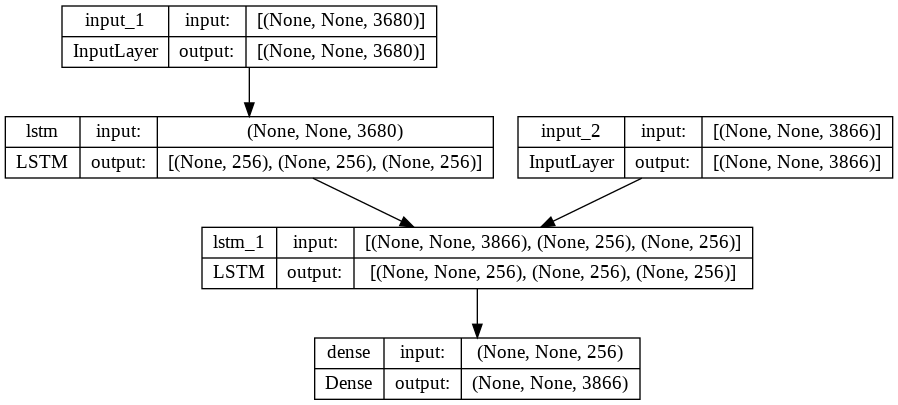

In [37]:
from keras.utils.vis_utils import plot_model
plot_model(training_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)   # plot model

In [38]:
training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')#Training

history1=training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.2)

training_model.save('training_model.h5')

Epoch 1/500
80/80 [==============================] - 13s 65ms/step - loss: 1.5765 - accuracy: 0.0160 - val_loss: 1.4902 - val_accuracy: 0.0142
Epoch 2/500
80/80 [==============================] - 3s 43ms/step - loss: 1.5328 - accuracy: 0.0152 - val_loss: 1.5090 - val_accuracy: 0.0139
Epoch 3/500
80/80 [==============================] - 4s 46ms/step - loss: 1.5244 - accuracy: 0.0150 - val_loss: 1.5867 - val_accuracy: 0.0117
Epoch 4/500
80/80 [==============================] - 3s 43ms/step - loss: 1.5189 - accuracy: 0.0151 - val_loss: 1.5577 - val_accuracy: 0.0143
Epoch 5/500
80/80 [==============================] - 3s 43ms/step - loss: 1.5129 - accuracy: 0.0155 - val_loss: 1.5778 - val_accuracy: 0.0142
Epoch 6/500
80/80 [==============================] - 3s 43ms/step - loss: 1.5110 - accuracy: 0.0155 - val_loss: 1.5762 - val_accuracy: 0.0139
Epoch 7/500
80/80 [==============================] - 3s 43ms/step - loss: 1.5071 - accuracy: 0.0155 - val_loss: 1.5813 - val_accuracy: 0.0140
Epoch

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Predictions

In [ ]:
from keras.models import load_model
training_model = load_model('training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

In [ ]:
latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]

In [ ]:
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [ ]:
from keras.models import load_model
training_model = load_model('training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)
    
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.
    
    #A variable to store our response word by word
    decoded_sentence = ''
    
    stop_condition = False
    while not stop_condition:
          #Predicting output tokens with probabilities and states
          output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
          
          #Choosing the one with highest probability
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_token = reverse_target_features_dict[sampled_token_index]
          decoded_sentence += " " + sampled_token
          
          #Stop if hit max length or found the stop token
          if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
          
          #Update the target sequence
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, sampled_token_index] = 1.
          
          #Update states
          states_value = [hidden_state, cell_state]
    return decoded_sentence

In [ ]:
class ChatBot:
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
  
  #Method to start the conversation
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on random dialogs. AMA!\n")
    
    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    self.chat(user_response)
  
  #Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")
    
  #Method to convert user input into a matrix
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix
  
  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response
  
  #Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
    return False
  
chatbot = ChatBot()

## Demo

In [ ]:
chatbot.start_chat()